In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

Code Adapted from: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH

## Helper Functions

In [2]:
def tsplot(y, lags=None, figsize=(20, 8), style='bmh'):
    # source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, zero=False, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Data Preparation

### Data Loading

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers = [f + '.JK' for f in lq45_tickers]
active_tickers.append('LQ45')

In [4]:
# Read downloaded stock Adjusted Close Price data
df_dict = {}
for ticker in tqdm(active_tickers):
    if ticker == 'LQ45':
        df_dict[ticker] = pd.read_csv(lq45_index_file)
    else:
        df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    
    ## Convert Adj Close to Returns
    df_dict[ticker]['return'] = df_dict[ticker]['Adj Close'].pct_change()
    df_dict[ticker]['log_return'] = np.log(1 + df_dict[ticker]['return'])
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 93.54it/s]


In [5]:
# Do Some basic data Operations (Fill NaN, take only certain data range, generate in sample an dout of sample data)
date_start = '2021-01-01'
date_breakpoint = '2022-01-01'

nan_handle_method = 'drop'

in_df = {}
out_df = {}
for ticker in tqdm(active_tickers):
    # Fill NaN values with the earliest data
    if nan_handle_method == 'bfill':
        df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    elif nan_handle_method == 'drop':
        df_dict[ticker].dropna(inplace=True)
        
    # Take In Sample and Out Sample Data
    df_dict[ticker]['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    in_df[ticker] = df_dict[ticker][(df_dict[ticker]['Date'] >= date_start) & 
                                                (df_dict[ticker]['Date'] < date_breakpoint)]
    out_df[ticker] = df_dict[ticker][df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Set Date as Index
    in_df[ticker] = in_df[ticker].reset_index(drop=True)
    in_df[ticker] = in_df[ticker].set_index('Date')
    out_df[ticker] = out_df[ticker].reset_index(drop=True)
    out_df[ticker] = out_df[ticker].set_index('Date')

100%|███████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 206.71it/s]


### Plots

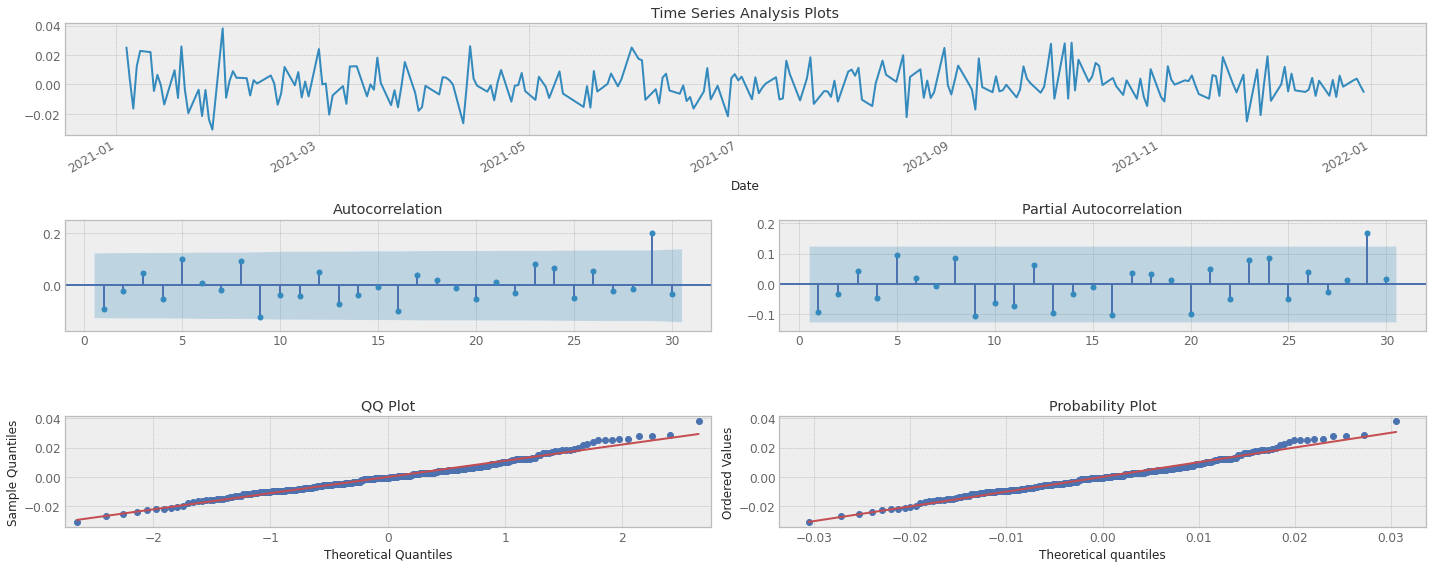

In [6]:
# Autocorrelation Plots
_ = tsplot(in_df[ticker]['log_return'], lags=30)

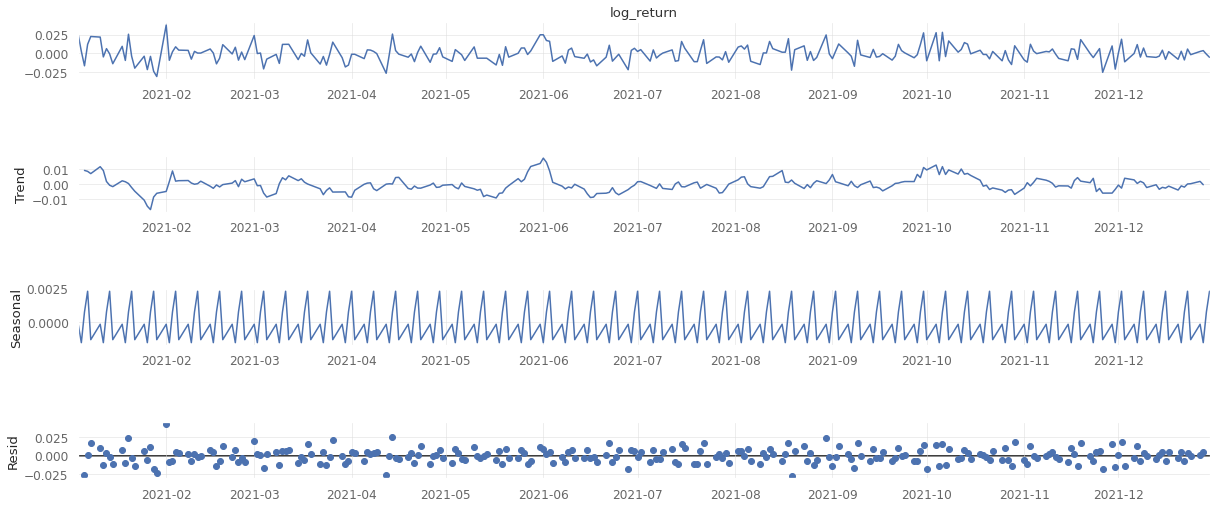

In [7]:
# Extract Trend and Seasonality, and take only residuals
df_buff = in_df[ticker]['log_return'].asfreq('B').fillna(method='ffill')
fig = smt.seasonal_decompose(df_buff, model='additive').plot()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

### Statistical Check

In [10]:
# Statistical Check (Stationarity and Normality)
# TODO - Implement Hurst Exponent and Ornstein-Uhlenbeck (or other mean reverting processes)
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Statistics
tickers = []

## Stationarity Statistic
adf_p_vals = []
stationary = []

## Normality Statistic
jb_p_vals = []
jb_skews = []
jb_kurtoses = []
normality = []

for ticker in active_tickers:
    tickers.append(ticker)
    
    # Stationarity Check
    adf_result = adfuller(in_df[ticker]['log_return'])
    
    adf_p_vals.append(adf_result[1])
    
    ## True if Null rejected, for 1% confidence interval
    s = True if adf_result[0] <= adf_result[4]['1%'] else False 
    stationary.append(s)
    
    # Normality Test
    jb_result = jarque_bera(in_df[ticker]['log_return'])
    
    jb_p_vals.append(jb_result[1])
    jb_skews.append(jb_result[2])
    jb_kurtoses.append(jb_result[3])
    
    ## True if Null NOT rejected, for 1% confidence interval
    n = True if jb_result[1] > 0.01 else False
    normality.append(n)

adf_df = pd.DataFrame({
                        'ticker': tickers,
                        'adf_p_val': adf_p_vals,
                        'stationary': stationary,
                        'jb_p_val': jb_p_vals,
                        'jb_skew': jb_skews,
                        'jb_kurtosis': jb_kurtoses,
                        'normality': normality
                        })
display(adf_df)

,ticker,adf_p_val,stationary,jb_p_val,jb_skew,jb_kurtosis,normality
0,ADRO.JK,1.474132e-29,True,1.395542e-26,0.775310,6.027363,False
1,AMRT.JK,5.570390e-29,True,4.159644e-42,1.110695,6.685375,False
2,ANTM.JK,5.658525e-06,True,2.967160e-69,1.405897,7.770493,False
3,ASII.JK,2.078539e-30,True,6.173224e-05,0.480208,3.980410,False
4,BBCA.JK,0.000000e+00,True,1.605516e-12,0.713953,4.799630,False
5,BBNI.JK,1.159054e-27,True,3.994984e-03,0.444456,3.532048,False
6,BBRI.JK,9.461988e-29,True,1.249307e-14,-0.190139,5.465087,False
7,BBTN.JK,3.481708e-13,True,1.262922e-03,0.314451,3.949482,False
8,BFIN.JK,4.650310e-28,True,2.443996e-17,0.927765,4.997566,False
9,BMRI.JK,4.171856e-30,True,1.635775e-04,0.249737,4.201980,False


## Process Modelling

### ARIMA

In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

best_orders = []
best_mdls = []
ljung_box = []
    
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2)
for p in tqdm(pq_rng):
    for d in d_rng:
        for q in pq_rng:
            tmp_mdl = smt.ARIMA(in_df[ticker]['log_return'], 
                                order=(p,d,q)).fit(method='innovations_mle')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p, d, q)
                best_mdl = tmp_mdl

best_orders.append(best_order)
best_mdls.append(best_mdl)

lb_pval = ljungbox(best_mdl.resid, lags=[best_order[2]])['lb_pvalue'].values[0]
ljung_box.append(lb_pval)

print('aic    : {:6.5f} | order: {}'.format(best_aic, best_order))
print(f'lb_pval: {lb_pval}')

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]

aic    : -1526.69505 | order: (3, 0, 2)
lb_pval: 0.8882402206255607


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                  247
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 770.348
Date:                Wed, 22 Jun 2022   AIC                          -1526.695
Time:                        12:28:53   BIC                          -1502.129
Sample:                             0   HQIC                         -1516.805
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.308e-05      0.001     -0.035      0.972      -0.001       0.001
ar.L1         -1.8903      0.062    -30.673      0.000      -2.011      -1.770
ar.L2         -1.1777      0.107    -10.991      0.0

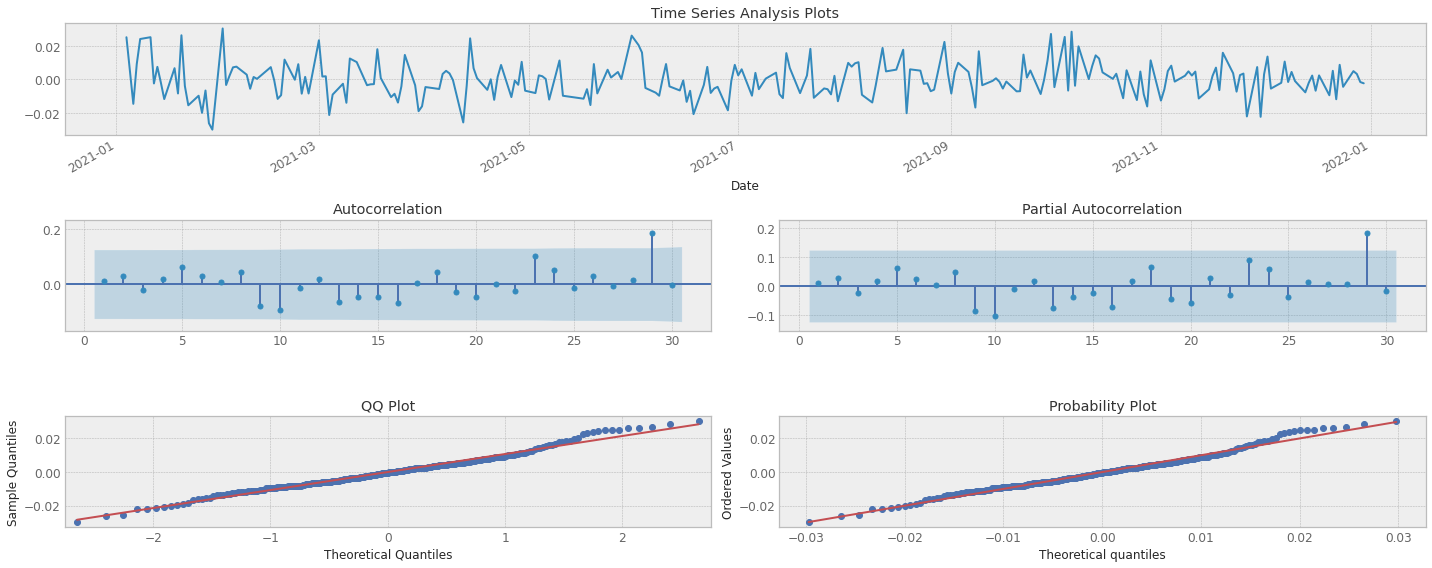

In [44]:
# ARIMA model Summary
_ = tsplot(best_mdl.resid, lags=30)
print(best_mdl.summary())

# TODO - Find other goodness of fit tests

### GARCH

In [ ]:
from arch import arch_model



### Forecast